# Hidden Markov Models for event segmentation

Hidden Markov Models (HMM) allow us to temporally cluster brain activity into discrete events, and to identify event correspondences between datasets. This tutorial describes how to fit HMMs to a narrative dataset, how to statistically verify the identified event boundaries, how to align multiple datasets, and how to apply HMMs to connectivity data. A full description of the model is given in [the Neuron paper](http://www.dpmlab.org/Neuron17.pdf).

In [2]:
%matplotlib inline
import deepdish as dd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import numpy as np
import brainiak.eventseg.event
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition
import seaborn as sns 

## Fitting HMM to activity patterns

The goal of the HMM is to identify chunks of time during which activity patterns remain relatively constant. To see if this is a reasonable model for our dataset, we can plot a timepoint-timepoint correlation matrix, showing the similarity between every pair of timepoints in our dataset (averaged over subjects).

In [3]:
#load and reduce data

not_the_fall=np.load("ten_subjects_notthefall.npy")

ntf_fix = np.nan_to_num(not_the_fall)
print(not_the_fall.shape)



(400, 110592)


In [4]:
fmri_bounds = np.zeros((10,9))
reservoir_bounds = np.zeros((10,9))


In [5]:
# this is a loop on 10 subjects and reservoirs that does the HMM segmentation - it is to see the variability!!
ev11 = brainiak.eventseg.event.EventSegment(10)
for file_count in range(10):
    #fmri
    ntf_subject = np.load('ntf_subj'+str(file_count+1)+'_small.npy')   
    ev11.fit(ntf_subject)
    bounds11 = np.where(np.diff(np.argmax(ev11.segments_[0], axis=1)))[0]
    print(bounds11)
    fmri_bounds[file_count,:]=bounds11
    
    #reservoir
    ntf_reservoir = np.load('ntf_reservoir'+str(file_count+1)+'.npy')   
    ev11.fit(ntf_reservoir)
    bounds11 = np.where(np.diff(np.argmax(ev11.segments_[0], axis=1)))[0]
    print(bounds11)
    reservoir_bounds[file_count,:]=bounds11

    
#fMRI bounds  [ 32  70 115 164 204 247 286 319 368] 400
#Reservoir bounds  [ 84 133 198 257 341 412 515 578 631] 682


   

[ 30  71 114 132 204 227 262 317 355]
[ 67 125 186 248 341 411 464 530 607]
[ 36  90 138 160 189 236 281 313 355]
[ 84 135 198 255 342 413 515 579 628]
[ 41  69 123 166 203 251 286 320 371]
[ 84 133 199 258 341 412 520 579 631]
[ 35  69  93 159 196 232 284 335 365]
[ 83 136 199 257 342 413 507 576 629]
[ 35  69 104 150 193 252 271 303 371]
[ 83 135 199 255 341 413 518 579 629]
[ 55  87 130 162 207 240 276 308 341]
[ 81 135 199 256 342 412 509 571 626]
[ 12  74 123 162 195 239 272 309 368]
[ 87 138 200 259 341 412 516 578 625]
[ 27  61 136 188 215 246 287 343 371]
[ 89 163 217 264 341 413 518 578 629]
[ 37  60  76 122 188 238 268 312 352]
[ 85 133 197 253 339 412 518 576 625]
[ 36  71 115 166 205 243 273 316 359]
[ 85 136 199 256 342 413 518 577 626]


In [6]:
# ok so now we make the final step and do the segmenation on the averages
for file_count in range(10):
    #fmri
    ntf_subject = np.load('ntf_subj'+str(file_count+1)+'_small.npy') 
    if file_count == 0:
        fmri_averages = ntf_subject
    else:
        fmri_averages = fmri_averages + ntf_subject
    
    #reservoir
    ntf_reservoir = np.load('ntf_reservoir'+str(file_count+1)+'.npy') 
    if file_count == 0:
        reservoir_averages = ntf_reservoir
    else:
        reservoir_averages = reservoir_averages + ntf_reservoir

reservoir_averages = reservoir_averages/10
fmri_averages = fmri_averages/10

In [7]:
ev_fmri = brainiak.eventseg.event.EventSegment(10)
ev_fmri.fit(fmri_averages)

ev_reservoir = brainiak.eventseg.event.EventSegment(10)
ev_reservoir.fit(reservoir_averages)


EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=10)

fMRI bounds  [ 32  70 115 164 204 247 286 319 368]
Reservoir bounds  [ 85 136 200 259 341 413 517 579 628]


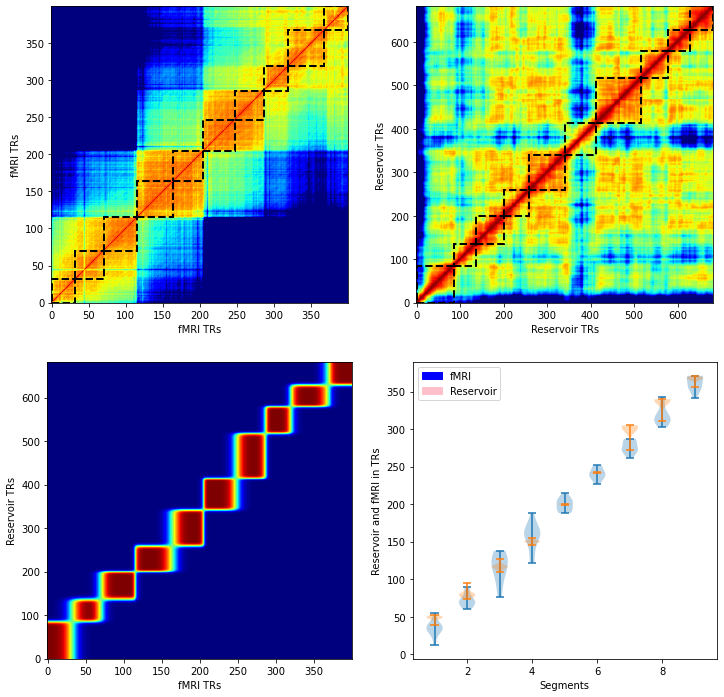

In [8]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
color='jet'
edge='black'
scale1=0.999
scale2=0.9
nTR=400

plt.imshow(np.corrcoef(fmri_averages), cmap=color, vmin = scale1, origin = 'lower')

bounds = np.where(np.diff(np.argmax(ev_fmri.segments_[0], axis=1)))[0]
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)
    
print('fMRI bounds ', bounds)
plt.xlabel('fMRI TRs')
plt.ylabel('fMRI TRs')

plt.subplot(2,2,2)

plt.imshow(np.corrcoef(reservoir_averages),  vmin=scale2, cmap=color, origin = 'lower')

nTR=682
bounds = np.where(np.diff(np.argmax(ev_reservoir.segments_[0], axis=1)))[0]
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)

print('Reservoir bounds ', bounds)    
plt.xlabel('Reservoir TRs')
plt.ylabel('Reservoir TRs')

plt.subplot(2,2,3)

plt.imshow(np.dot(ev_fmri.segments_[0], ev_reservoir.segments_[0].T).T,aspect='auto',cmap='jet',origin='lower')


plt.xlabel('fMRI TRs')
plt.ylabel('Reservoir TRs')


plt.subplot(2,2,4)

#plt.imshow(np.dot(ev_fmri.segments_[0], ev_reservoir.segments_[0].T).T,aspect='auto',cmap='jet')#origin='lower',
plt.violinplot(fmri_bounds)
plt.violinplot(reservoir_bounds/682*400)

plt.xlabel('Segments')
plt.ylabel('Reservoir and fMRI in TRs')

red_patch = patches.Patch(color='pink', label='Reservoir')
#plt.legend(handles=[red_patch], loc='upper left')

blue_patch = patches.Patch(color='blue', label='fMRI')
plt.legend(handles=[blue_patch, red_patch], loc='upper left')



#fig.tight_layout()
plt.savefig('hmm_notthefall_reservoir_fmri_10instances-3panels.png', dpi=600)


In [10]:
#fmri_bounds
#reservoir_bounds/682*400
i=0
for i in range(10):
    correlation, p_value = stats.pearsonr(fmri_bounds[i], reservoir_bounds[i])
    print('correltion: ',correlation)
    print('p_value: ', p_value)


correltion:  0.9974606540450421
p_value:  2.7101349728167593e-09
correltion:  0.993153078186678
p_value:  8.687129607863834e-08
correltion:  0.9945849460029581
p_value:  3.8269976193677945e-08
correltion:  0.9973828531365085
p_value:  3.0118255757167865e-09
correltion:  0.9911934637822524
p_value:  2.0923325570285976e-07
correltion:  0.9972583533920605
p_value:  3.5433906097811625e-09
correltion:  0.987931031103535
p_value:  6.284571752638278e-07
correltion:  0.9851064268650231
p_value:  1.308361734266367e-06
correltion:  0.9946794057737056
p_value:  3.598726716556866e-08
correltion:  0.9929242089538408
p_value:  9.74446794619274e-08
